# 🧠 Extract spatial "hotspots" of activity from voltage imaging recording
### Steps

1) Import stuff 
2) Set data with labelled blobs of significant activity 
3) Create class for analysis and get normalised + temporally summed 2D activity heatmaps
4) Get distance between each heatmap, and threshold for significance using spatial shuffling
5) Cluster heatmaps based on distance, get similarity matrix 
6) ? perform background correction: remove overall weakly correlated heatmaps which are more likely noise
7) Get heatmaps & similarity matrices for each level of the linkage hierarchy. Plot the matrices w clusters highlighted.
8) 

To do:
1) Check significance calculation between clusters
2) Improve speed of tree-search algorithm
4) Memory map results

### 1) Import stuff

In [1]:
import numpy as np, os, sys, importlib, glob, matplotlib.pyplot as plt, seaborn as sns, pickle as pkl, itertools
from scripts import dfFunc as f, vFunc as vF, pltFunc as pF, analyse, synFunc as sF, synAnalysis as synAn
sns.set_style('white')
#sys.path.append('../NetAnalysis/Ensembles/scripts')
#import eFunctions as eF, ePltFunc as eP
def rel(): importlib.reload(f),importlib.reload(vF),importlib.reload(pF),importlib.reload(synAn), importlib.reload(analyse), importlib.reload(sF) 

2025-11-07 20:01:15,275	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Using gpu 

<frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.


### 2 - 3) Specify data and create class

Load data with blobs of significant activity from getActivity.ipynb. Get heatmaps of activity summed over temporal frames: ie, each heatmap is of length N x M pixels, and each value corresponds to the (normalised) temporally summed intensity over the blob of activity. The activity is normalised because if 2 heatmaps have the same intensity distribution, apart from the scaled magnitude, they probably come from the same synaptic input! 

In [2]:
Data = 'data/cntData_test.pkl'      # Path to data with labelled "blobs" of activity (getActivity.ipynb)
synClust = synAn.synClust(Data)         # Analysis class. 

getting continuous activity episodes + labels... 463  activity episodes
getting normalised activity episodes... (using gpu for temporal heatmap)


### 4) Get measure of distance between each heatmap, and threshold distance for significance with spatial shuffling 

Find a distance measure between all heatmaps to use for clustering. Set a threshold for significance by randomly spatially shuffling every heatmap N times, recalculating distance between every heatmap pair, and using a cutoff based on these distribution of values. 

In [3]:
rel()
PERCENTILE = 90                 # Percentile threshold for significance (input 100 - this bc it's distance...)
Runs = 100                      # Number of shuffling runs
batchSize = (10, 10)            # Batch sizes for GPU: reduce if running out of memory....
METRIC = 'correlation'          # Metric for calculating similarity between heatmaps

synClust.getDistance(Runs, batchSize, percentile = 100 - PERCENTILE, \
                     shufflePlot = False, Metric = METRIC) # 3000 episodes = 140 seconds for 1k runs

getting distance
getting random heatmap locations..getting random distances..


### 5-6) Cluster heatmaps based on distance and get similarity matrix. Perform a final background correction (optional?)

Perform clustering on the heatmap distance matrix, and create a matrix of cluster hierarchies, and a similarity matrix.  

In [4]:
synClust.getClusters()

getting matrix of cluster hierarchies


Background correction (optional). The rationale for this is because heatmaps that are overall weakly correlated are probably more likely to be due to background noise. This finds the distribution of mean correlations of all heatmaps that are restricted to "non-cell" locations. Any heatmaps that have a mean correlation less than a threshold, based on this distribution, are removed.  

In [5]:
CORRECT = True                              # Perform background correction?
BG_PERCENTILE = 90                          # %ile for cutoff
SPLITS = 1                                  # For GPU: increase if memory issues....

print('uncorrected activity matrix shape: ', synClust.actM.shape)
synClust.bgCorrection(Percentile = BG_PERCENTILE, Correct = CORRECT, SPLITS = SPLITS) # change SPLIT for GPU memory use
print('corrected activity matrix shape: ', synClust.actM.shape)

uncorrected activity matrix shape:  (1435, 463)
getting distance
corrected activity matrix shape:  (1435, 163)


Re-calculate clustering etc if background correction is done

In [6]:
synClust.getClusters()

getting matrix of cluster hierarchies


### 7) Get heatmaps within each cluster for each level of the linkage hierarchy. Plot ordered similarity matrices. 

Plot matrices corresponding to different levels of the clustering hierarchy (starting with a single cluster), with each cluster ordered by within-cluster distance. Get heatmaps corresponding to each cluster at hierarchy level.  

In [7]:
nHierarchies = 12               # Choose arbitrary upper number of cluster hierarchies (just need enough to cover most activity...)

plt.ioff()
rows = np.linspace(-(nHierarchies + 1), -1, nHierarchies + 1).astype(int)
synClust.plotSortSim(rows, sHigh = False, save = False, Par = False)
plt.close('all')
plt.ion()

Get a cluster hierarchy level that "covers" a certain proportion of the total activity (eg, 90%). This level will then be used to search for all significantly separated clusters....   

In [8]:
PERC_COVER = 0.95

try:
      print('cluster level and percentage for > 90 perc cell coverage is',\
            [(K,V) for K, V in synClust.activityCover['cell'].items() if V > PERC_COVER][-1])
except:
      print("not enough hierarchies to cover {} percent of cells activity!".format(PERC_COVER * 100))

try:
      print('cluster level and percentage for > 90 perc total coverage is',\
            [(K,V) for K, V in synClust.activityCover['total'].items() if V > PERC_COVER][-1])
except:
      print("not enough hierarchies to cover {} percent of total activity!".format(PERC_COVER * 100))

not enough hierarchies to cover 95.0 percent of cells activity!
not enough hierarchies to cover 95.0 percent of total activity!


Select the number of hierarchies used to find spatially significant clusters based on the % of activity covered. Eg, if 20 levels cover say 90% of the activity, choose this.  

In [9]:
nHierarchies = 12
synClust.rowData = synClust.rowData[-nHierarchies:]

Optional - plot a few things as a sanity check:
1) Mean heatmap of activity associated with a cluster at each level
2) Create movies of just the "hotspots" corresponding to a cluster (pick how many hotspots to shorten!) 

In [10]:
plt.ioff()

synClust.plotHmaps()                                    # Plot mean heatmap associated with clusters for EVERY level of hierachy                                         

HIERARCHY = 5       # Cluster hierarchy to create exemplar videos of activity
N_BLOBS = 10        # Number of activity episodes to display for each cluster
SPEED = 0.5         # Speed of movie
#synClust.getClustMovies(HIERARCHY, Speed = 0.5, Short = N_BLOBS)     # Create video

plt.close('all')
plt.ion()

/home/alex/Dropbox/Research/Science/Projects/Columbia/Code/Analysis/github/voltage/scripts/synFunc.py:477: RuntimeWarning: divide by zero encountered in divide
  pixWt = np.nan_to_num(1/pixOverlaps,0,posinf=0)


### 8) Search through cluster hierarchy & find spatially separated clusters

Algorithm to search through cluster hierarchy and identify significantly separated spatial clusters. Save cluster labels and plot the mean heatmap of each significant cluster.

Determine whether to split a parent cluster into 2 child clusters:
1) Compute the silhouette score of the child clusters
2) Generate N surrogate Gaussian datasets of the parent
3) Cluster N surrogate datasets into 2 separate clusters (K-means) and get N surrogate silhouette scores
4) Check if the child silhouette score is > than the Xth percentile of the parent-based surrogates

In [11]:
NORM = True                    # Whether to normalise Gaussians when comparing 2 clusters
THRESH = 95                     # Significant threshold for distinct clusters based on random 
LABELS = True                   # Whether to plot the cluster label number next to each heatmap

synClust.getClusterSignificance(NORM, THRESH, LABELS)


moving onto cluster 309. Remaining labels are
 [309, 303, 318, 293, 314, 291, 253, 305, 306, 287, 278]



/home/alex/Dropbox/Research/Science/Projects/Columbia/Code/Analysis/github/voltage/scripts/synFunc.py:1411: RuntimeWarning: invalid value encountered in divide
  points = [getDots(np.nan_to_num(HM/HM), Scale=1) for HM in [hm1, hm2]]
2025-11-07 20:02:04,921	INFO worker.py:2012 -- Started a local Ray instance.
/home/alex/miniconda3/envs/voltage_3/lib/python3.9/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=7198) <frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
(pid=7198) <frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cuda module is deprecated and will b

Clusters [293, 303, 306, 308, 318] are separate. Adjacent cluster sig between 309 & 278 is 100.0
Clusters [293, 303, 306, 308, 318, 278] are separate. Adjacent cluster sig between 309 & 287 is 100.0


(pid=gcs_server) [2025-11-07 20:02:34,265 E 6917 6917] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=7260) <frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead. [repeated 47x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(pid=7260) <frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead. [repeated 47x across cluster]


Clusters [293, 303, 306, 308, 318, 278, 287] are separate. Adjacent cluster sig between 309 & 291 is 100.0


(raylet) [2025-11-07 20:02:34,880 E 7097 7097] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(KmFit pid=7198) [2025-11-07 20:02:35,275 E 7198 7481] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-07 20:02:35,497 E 6625 7196] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Clusters [293, 303, 306, 308, 318, 278, 287, 291] are separate. Adjacent cluster sig between 309 & 314 is 100.0

testing children of cluster 309

moving onto cluster 303. Remaining labels are
 [303, 318, 293, 314, 291, 253, 305, 306, 287, 278]

Clusters [278, 291, 293, 306, 309, 314] are separate. Adjacent cluster sig between 303 & 287 is 100.0
Clusters [278, 291, 293, 306, 309, 314, 287] are separate. Adjacent cluster sig between 303 & 308 is 100.0
Clusters [278, 291, 293, 306, 309, 314, 287, 308] are separate. Adjacent cluster sig between 303 & 318 is 100.0

testing children of cluster 303

moving onto cluster 318. Remaining labels are
 [318, 293, 314, 291, 253, 305, 306, 287, 278]

Clusters [278, 287, 291, 293, 306, 309] are separate. Adjacent cluster sig between 318 & 303 is 100.0
Clusters [278, 287, 291, 293, 306, 309, 303] are separate. Adjacent cluster sig between 318 & 308 is 100.0
Clusters [278, 287, 291, 293, 306, 309, 303, 308] are separate. Adjacent cluster sig between 318 

In [ ]:
#sF.plotMeanEnsHm(synClust.actM, synClust.rowData, labelText=True, Dim = synClust.spatialDims, \
#                 Save = 'norm' + str(NORM) + '_Labels_thresh' + str(THRESH) + '_', \
#                 clusterList = synClust.clLabels, clusterLabels = [int(tCl) for tCl in synClust.sigClusters],\
#                    UPSAMPLE = 7)

### ***Testing***

Plot a cluster and all of it's child subclusters: either on the same plot or different plots

In [ ]:
CLUSTER = 307                                                       # Cluster number to plot

sF.plotSubClusters(CLUSTER, synClust.clTree, synClust.clLabels, synClust.actM, \
                   synClust.rowData, Dim = synClust.spatialDims)    # Cluster is saved in figures folder

Test the significance of any 2 arbitrary clusters

In [113]:
## TEST SIGNIFICANCE OF ANY 2 ARBITRARY CLUSTERS
rel()
sig, Dots, Hms, gData, si, scores = sF.clusterSigTest((254,305), synClust.rowData, \
                                    synClust.actM, Dim = synClust.spatialDims, nDots = 1000, norm = True)

print("Separation significance is {}. Silhouette score for original clusters is {}. Mean/std of \n \
silhouette scores for clusters approximated by single Gaussian is {}/{}".format(sig, si, \
    np.round(np.mean(scores), 3), np.round(np.std(scores), 3)))

Separation significance is 6.0. Silhouette score for original clusters is 0.3952687382698059. Mean/std of 
 silhouette scores for clusters approximated by single Gaussian is 0.412/0.009


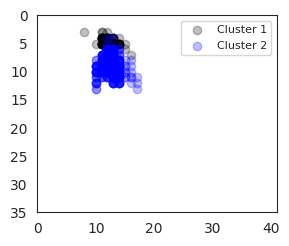

In [111]:
# PLOT TEST DATA
ALPH = 0.25
(Y, X) = synClust.spatialDims

fig, ax = plt.subplots(1, 1, figsize = (3, 3 * (Y / X)))

ax.scatter(np.array(Dots[0]).T[1],np.array(Dots[0]).T[0], alpha = ALPH, color = 'black')
ax.scatter(np.array(Dots[1]).T[1],np.array(Dots[1]).T[0], alpha = ALPH, color = 'blue')

#ax.scatter(np.array(Dots[2]).T[1],np.array(Dots[2]).T[0],alpha=0.1)
#ax.scatter(gData[0].T[1], gData[0].T[0], alpha = 0.1, color = 'green')

ax.set_ylim([synClust.spatialDims[0],0]), ax.set_xlim([0,synClust.spatialDims[1]])

ax.legend(['Cluster 1','Cluster 2','Estimated gaussian'], fontsize = 8)

fig.tight_layout()